In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# zip_path = '/content/drive/My Drive/Colab Notebooks/CNN_assignment.zip'

# # Unzip the file into a specified directory
# !unzip -q "$zip_path" -d "/content/drive/My Drive/unzipped/"

In [3]:
# import shutil
# # Specify the directory you want to delete
# dir_path = '/content/drive/MyDrive/Melanoma '

# # Check if the directory exists
# if os.path.exists(dir_path):
#     # Use shutil.rmtree() to delete the directory and its contents
#     shutil.rmtree(dir_path)
#     print(f"Directory '{dir_path}' has been deleted.")
# else:
#     print(f"Directory '{dir_path}' does not exist.")

In [4]:
#library imports
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import PIL
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPool2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [5]:
train_dir = "/content/drive/MyDrive/Skin_cancer/Train"
test_dir = "/content/drive/MyDrive/Skin_cancer/Test"

In [6]:
image_count_train = len(list(pathlib.Path(train_dir).glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(pathlib.Path(test_dir).glob('*/*.jpg')))
print(image_count_test)

2239
118


In [7]:
class_names = np.array([item.name for item in pathlib.Path(train_dir).glob('*')])
print(class_names)

['actinic keratosis' 'basal cell carcinoma' 'dermatofibroma' 'melanoma'
 'nevus' 'pigmented benign keratosis' 'seborrheic keratosis'
 'squamous cell carcinoma' 'vascular lesion']


### Load Data using keras.Preprocessing

### **Create a Dataset**

In [8]:
# Data processing by setting the hyperparameters
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training and 20% for Validation

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [12]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### **Visulaize the date using Matplotlib**

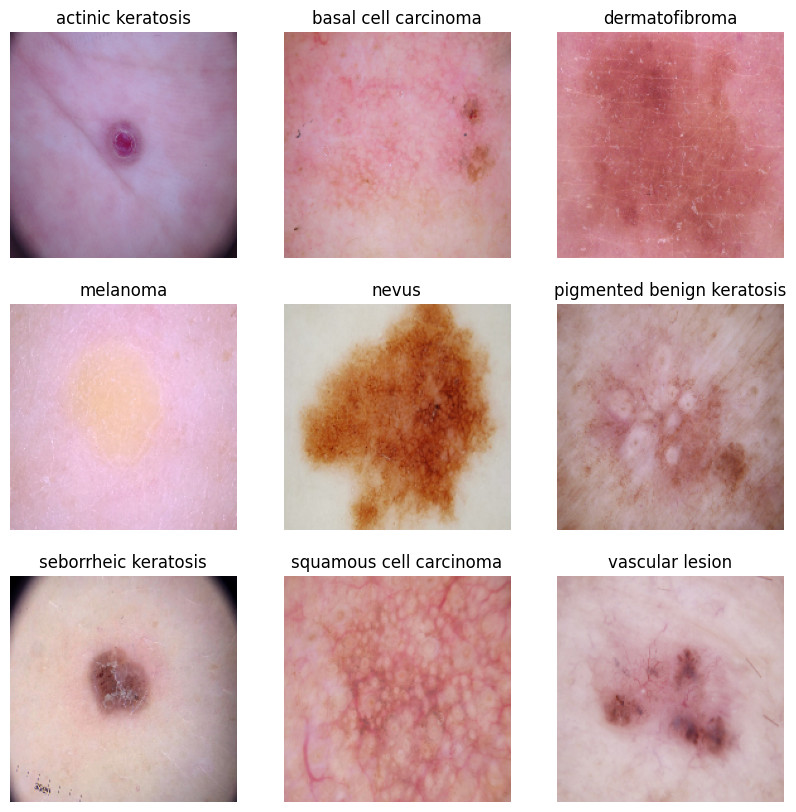

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [14]:
count= []
for path in pathlib.Path(train_dir).iterdir():
    if path.is_dir():

      count.append(len([name for name in os.listdir(path)
            if os.path.isfile(os.path.join(path, name))]))

#name of the classes
sub_directory = [name for name in os.listdir(train_dir)
                if os.path.isdir(os.path.join(train_dir, name))]

#return dataframe with image count and class.
df_train= pd.DataFrame(list(zip(sub_directory,count)),columns =['Class_Name', 'No.of Images in train dir'])
df_train

,Class_Name,No.of Images in train dir
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


In [15]:
count= []
for path in pathlib.Path(test_dir).iterdir():
    if path.is_dir():

      count.append(len([name for name in os.listdir(path)
            if os.path.isfile(os.path.join(path, name))]))

#name of the classes
sub_directory = [name for name in os.listdir(test_dir)
                if os.path.isdir(os.path.join(test_dir, name))]

#return dataframe with image count and class.
df_test= pd.DataFrame(list(zip(sub_directory,count)),columns =['Class_Name', 'No. of Images in test dir'])
df_test

,Class_Name,No. of Images in test dir
0,actinic keratosis,16
1,basal cell carcinoma,16
2,dermatofibroma,16
3,melanoma,16
4,nevus,16
5,pigmented benign keratosis,16
6,seborrheic keratosis,3
7,squamous cell carcinoma,16
8,vascular lesion,3


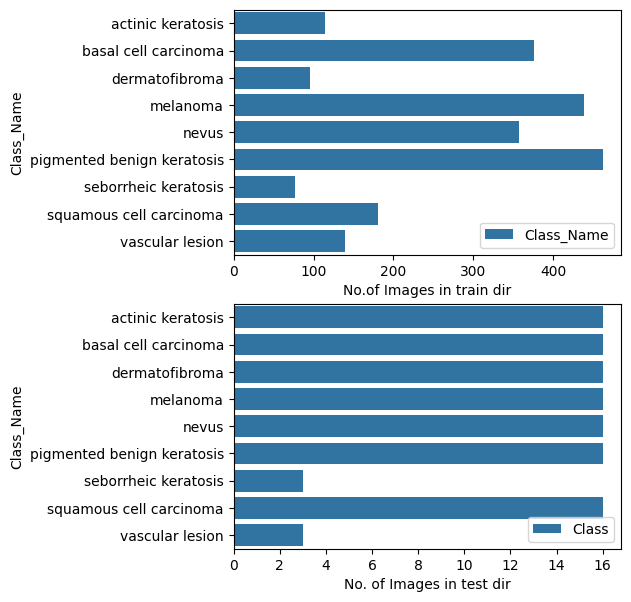

In [16]:
plt.figure(figsize=(5,7))
plt.subplot(2,1,1)
sns.barplot(x="No.of Images in train dir", y="Class_Name", data=df_train,
            label="Class_Name")
plt.subplot(2,1,2)
sns.barplot(x="No. of Images in test dir", y="Class_Name", data=df_test,
            label="Class")
plt.show()

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

**Dataset.cache()** keeps the images in memory after they're loaded off disk during the first epoch.

**Dataset.prefetch()** overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Create the model**

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [18]:
input_size = (180, 180, 3)
lr = 1e-3
init = 'normal'
activation = 'relu'

model = Sequential()
model.add(Rescaling(1./255, input_shape=input_size))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_size))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(7, 7), activation=activation))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(11, 11), activation=activation))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation=activation))

model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 83, 83, 64)          │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 83, 83, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 41, 41, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 31, 31, 128)         │         991,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 31, 31, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      14,746,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,844,169 (60.44 MB)

 Trainable params: 15,843,785 (60.44 MB)

 Non-trainable params: 384 (1.50 KB)

### **Compile the model**
Choose an appropirate optimiser and loss function for model training

In [20]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [21]:
# Train the model
epochs = 20
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', verbose=1)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  # callbacks = [earlystop]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.2377 - loss: 22.0253 - val_accuracy: 0.1790 - val_loss: 45.3971
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 73ms/step - accuracy: 0.3158 - loss: 14.5204 - val_accuracy: 0.2125 - val_loss: 15.7946
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.3798 - loss: 6.9333 - val_accuracy: 0.2170 - val_loss: 25.4027
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.3505 - loss: 4.6659 - val_accuracy: 0.2483 - val_loss: 7.3906
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.4081 - loss: 2.9501 - val_accuracy: 0.2081 - val_loss: 4.8700
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.4155 - loss: 2.0817 - val_accuracy: 0.1834 - val_loss: 14.6298
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.4736 - loss: 1.9659 - val_accuracy: 0.2998 - val_loss: 10.5133
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.4626 - loss: 1.8152 - val_accuracy: 0.

### **Visulaizing the training data**

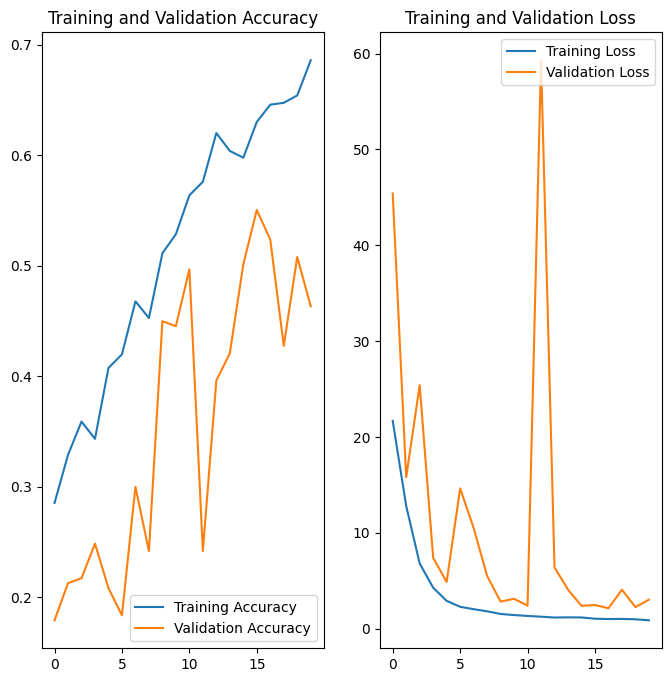

In [22]:
# Visulaizing the training data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 20
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training accuracy of the model seems to increase linearly whereas validation accuracy remained stagnant around 55%
High training accuracy means the model has learnt the noise in the data as well, however its poor performance on validation data shows lack of generalisability of the model.
The above observations confirm the case of overfitting. To mitigate overfitting augmentation technique will be used. Since the training data available is less, we will generate new samples by slightly modifying the existing training data (for eg. flipping the image horizontally/vertically, slightly rotating the image etc) and use them for training the model as well.

In [23]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6234 - loss: 1.2790
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4794 - loss: 2.9274
Accuracy:  0.6283482313156128
Validation Accuracy:  0.463087260723114
Loss:  1.2667397260665894
Validation Loss 3.0277042388916016


### Data is augumented t improve the model performance

In [24]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma',
        'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis',
         'squamous cell carcinoma','vascular lesion']
train_batches = datagen.flow_from_directory(train_dir,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(test_dir,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)


Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


#### **Train the model after Data augumentaion**

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 83, 83, 64)          │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 83, 83, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 41, 41, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 31, 31, 128)         │         991,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 31, 31, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      14,746,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,531,741 (181.32 MB)

 Trainable params: 15,843,785 (60.44 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 31,687,572 (120.88 MB)

In [26]:
# Train the model
epochs = 20
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, mode='auto', verbose=1)
history = model.fit(
  train_batches,
  validation_data=valid_batches,
  epochs=epochs,
  callbacks = [earlystop]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.5155 - loss: 1.7869 - val_accuracy: 0.1949 - val_loss: 8.0050
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.5209 - loss: 1.5146 - val_accuracy: 0.3220 - val_loss: 4.1181
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5485 - loss: 1.4149 - val_accuracy: 0.3559 - val_loss: 3.8240
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.5253 - loss: 1.3923 - val_accuracy: 0.2542 - val_loss: 8.8700
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5818 - loss: 1.2482 - val_accuracy: 0.2881 - val_loss: 3.6191
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.5692 - loss: 1.2789 - val_accuracy: 0.2881 - val_loss: 4.8839
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5727 - loss: 1.2323 - val_accuracy: 0.3390 - val_loss: 3.6479
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.5752 - loss: 1.1979 - val_accuracy: 0.2966 - val_loss: 3.2292
E

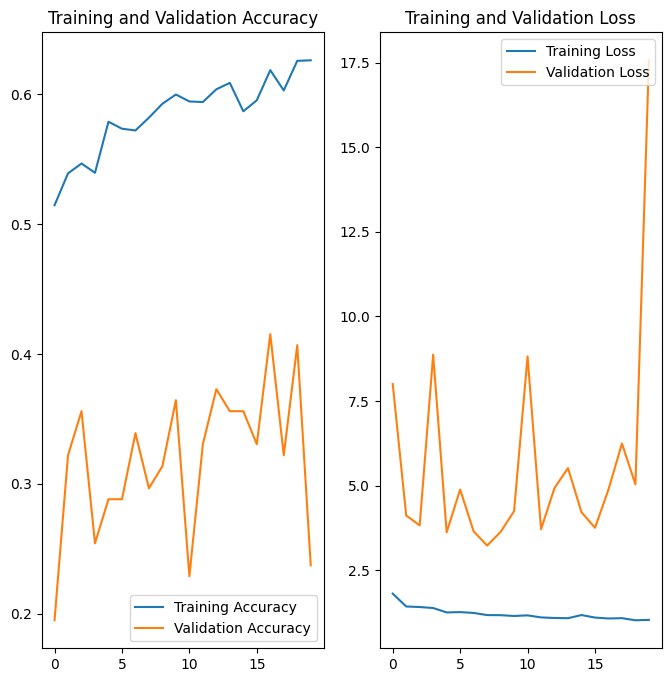

In [28]:
# Plotting the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 20
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4730 - loss: 6.5257
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4511 - loss: 14.6571
Accuracy:  0.4681919515132904
Validation Accuracy:  0.4317673444747925
Loss:  5.76981782913208
Validation Loss 12.99720287322998


In [30]:
count= []
for path in pathlib.Path(train_dir).iterdir():
    if path.is_dir():

      count.append(len([name for name in os.listdir(path)
            if os.path.isfile(os.path.join(path, name))]))

#name of the classes
sub_directory = [name for name in os.listdir(train_dir)
                if os.path.isdir(os.path.join(train_dir, name))]

#return dataframe with image count and class.
df_train= pd.DataFrame(list(zip(sub_directory,count)),columns =['Class_Name', 'No.of Images in train dir'])
df_train

,Class_Name,No.of Images in train dir
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


Model Performance is not imporved, so the imbalanced data needs to be balanced using augumentations, increasing each class count to 500

In [31]:
!pip install Augmentor

In [32]:
import Augmentor

In [33]:
path_to_training_dataset=train_dir+"/"

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_cancer/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DFC16E07B80>: 100%|██████████| 500/500 [00:24<00:00, 20.74 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_cancer/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DFC702B8700>: 100%|██████████| 500/500 [00:22<00:00, 22.41 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DFC9003CCD0>: 100%|██████████| 500/500 [00:19<00:00, 25.51 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_cancer/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7DFC22340940>: 100%|██████████| 500/500 [01:31<00:00,  5.44 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DFC22039DE0>: 100%|██████████| 500/500 [01:27<00:00,  5.71 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DFC701F05E0>: 100%|██████████| 500/500 [00:18<00:00, 27.61 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DFC989BAB60>: 100%|██████████| 500/500 [00:43<00:00, 11.54 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DFC22321690>: 100%|██████████| 500/500 [00:20<00:00, 24.78 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DFC98BAFFD0>: 100%|██████████| 500/500 [00:19<00:00, 25.96 Samples/s]


In [34]:
image_count_train = len(list(pathlib.Path(train_dir).glob('*/output/*.jpg')))
print(image_count_train)

4500


### **Lets see the distribution of augmented data after adding new images to the original training data.**

In [35]:
path_list = [x for x in glob.glob(os.path.join(pathlib.Path(train_dir), '*','output', '*.jpg'))]

In [36]:
Balanced_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(train_dir, '*','output', '*.jpg'))]


In [37]:
dataframe_dict_new = dict(zip(path_list, Balanced_list_new))

In [38]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [39]:
new_df['Label'].value_counts()

,count
Label,
actinic keratosis,500
basal cell carcinoma,500
dermatofibroma,500
melanoma,500
nevus,500
pigmented benign keratosis,500
seborrheic keratosis,500
squamous cell carcinoma,500
vascular lesion,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [40]:
data_dir_train="/content/drive/MyDrive/Skin_cancer/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [42]:
input_shape = (180,180,3)
lr = 1e-4
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dropout(0.25))
model.add(Dense (9, activation='softmax'))

## Number of classes is 9
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 39, 39, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 46208)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      23,659,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,887,945 (91.13 MB)

 Trainable params: 23,887,945 (91.13 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
# checkpoint = ModelCheckpoint("/content/drive/MyDrive/Skin_cancer/model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)

In [44]:
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[earlystop])

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 59s 307ms/step - accuracy: 0.2278 - loss: 2.1020 - val_accuracy: 0.3838 - val_loss: 1.5732
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 71s 273ms/step - accuracy: 0.4238 - loss: 1.5287 - val_accuracy: 0.4848 - val_loss: 1.4008
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 254ms/step - accuracy: 0.4724 - loss: 1.3948 - val_accuracy: 0.5152 - val_loss: 1.2818
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 249ms/step - accuracy: 0.5307 - loss: 1.2415 - val_accuracy: 0.5019 - val_loss: 1.3102
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 245ms/step - accuracy: 0.5691 - loss: 1.1528 - val_accuracy: 0.5939 - val_loss: 1.1107
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 254ms/step - accuracy: 0.6089 - loss: 1.0353 - val_accuracy: 0.5999 - val_loss: 1.0645
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 260ms/step - accuracy: 0.6541 - loss: 0.9584 - val_accuracy: 0.6318 - val_loss: 1.0394
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 249ms/step - accuracy: 0.7185 - loss: 0

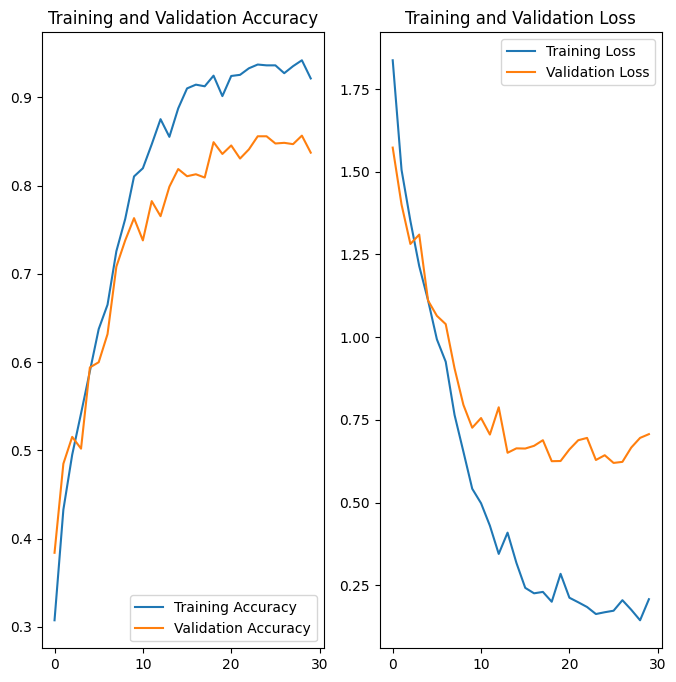

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 30 #edit here
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After balancing the data, From training accuracy and validation accuracy we can conclude that the model is stable val accuracy is 83.74  futher increasing the number of epochs will improve the accuracy.

In [46]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 201ms/step - accuracy: 0.9467 - loss: 0.1405
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.8488 - loss: 0.5953
Accuracy:  0.9538204669952393
Validation Accuracy:  0.8374164700508118
Loss:  0.11895520985126495
Validation Loss 0.7068008184432983


### **Model Prediction on Test data**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Actual Class dermatofibroma
Predictive Class basal cell carcinoma


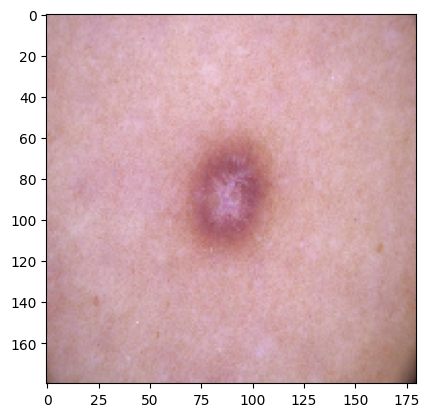

In [49]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img
class_names=os.listdir('/content/drive/MyDrive/Skin_cancer/Test')
class_num=2
Test_image_path = os.path.join(pathlib.Path(test_dir), class_names[class_num], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)

pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[class_num] +'\n'+ "Predictive Class "+pred_class )